In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# <span style="color:orange"> Numerical Simulation Laboratory: Lecture 08</span>

The aim of this lecture is to use Monte Carlo methods to evaluate the GS energy for a quantum 1D system of a single particle subject to the potential:
$$
V(x):=\dfrac{x^2}{2}\bigl[2x^2-5\bigr]
$$
The symmetries of such function will allow us to establish some properties of the spectrum of the Hamiltonian and of its eigenstates:
- It being a lower bounded function that diverges as $\lvert x\rvert\to\infty$ tells us that the specturm is discrete.
- Its invariance under spatial inversion allows us to choose the eigenfunctions among even and odd functions. Furthermore, a well-known Theorem tells us that the eigenstates will be alternately even and odd starting from the GS (which is even). 

## Exercise 08.2: Variational MC
According to the previous remark, we take as an educated guess:
$$
\psi_{\mu,\sigma}(x)=\exp\biggl[-\dfrac{(x-\mu)^2}{2\sigma^2}\biggr]+\exp\biggl[-\dfrac{(x+\mu)^2}{2\sigma^2}\biggr]
$$
up to a normalization factor. The parameters $\sigma,\mu$ are to be chosen in such a way that they minimize the expected value of the Hamiltonian on such state:
$$
\langle H\rangle(\mu,\sigma):=\dfrac{1}{\int_{\mathbb{R}}\lvert\psi_{\mu,\sigma}(y)\rvert^2\,dy}\int_{\mathbb{R}}\psi^*_{\mu,\sigma}(x)(H\psi_{\mu,\sigma})(x)\,dx
$$
Hence, the problem is reduced to the optimization of the function $(\mu,\sigma)\mapsto \langle H\rangle(\mu,\sigma)$ in the plane $\mathbb{R}^2$ (actually it is sufficient to restict ourselves to the first quadrant because the trial function exhibits simmetry under reflection in both coordinates both individually and together). Consequently, we will use a simulated annealing algorithm organized in the following fashion:
- We will pick $50$ increasing values for the inverse temperature $\beta_n\in[0.002,2000] $ (i.e. $T_n\in[0.0005, 500]$). To avoid the annealing being too abrupt, we construct the sequence $\{\beta_n\}_n$ from $50$ equally spaced numbers $\xi_n$ with the rule $$\beta_n:=\xi_n^p\equiv (\xi_0+n\Delta\xi)^p$$ for $p=25$. The choice of the exponent guarantees that the temperature $T=\beta=1$ is reached gently.
- For each $\beta_n$ we construct a random walk of $300$ steps in the plane $(\mu,\sigma)$: for fixed $k=1,\dots, 300$ we put forth a move $(\mu,\sigma)$ picked from a uniform distribution in the squared centered in $(\mu_k,\sigma_k)$ of side $\ell=0.1$. An evaluation of the function $\langle H\rangle$ tells us whether we should accept such configuration as the $(k+1)$-th or reject it.
- $\langle H\rangle$ (which is basically an integral) is computed with an importance sampling method. The PDF:$$u_{\mu,\sigma}(x):=\dfrac{\lvert\psi_{\mu,\sigma}(x)\rvert^2}{\int_{\mathbb{R}}\lvert\psi_{\mu,\sigma}(y)\rvert^2\,dy} $$ is sampled with a Metropolis algorithm of $10^4$ steps with a uniform kernel of radius $\delta=5$. The integral thus becomes:
$$
\langle H\rangle(\mu,\sigma)=\int_{\mathbb{R}}\dfrac{(H\psi_{\mu,\sigma})(x)}{\psi_{\mu,\sigma}(x)}\,u_{\mu,\sigma}(x)dx
$$

Once the simulated annealing has given its results, the integral is evaluated once again for the minimizing configuration for a number of $10^7$ MC steps divided into $100$ blocks in order to estimate the uncertainty. In this evaluation we will also 'draw' the shape of the resulting trial function by filling in an histogram and we will compare it with a numerical solution obtained by discretization of the eigenvalue problem (thus reducing it to the diagonalization of a matrix).

In [2]:
# discretization in 1000 points
def Vpot(x):
    return (x**2 - 2.5)*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] 
V = Vpot(x)

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)
E,psi = np.linalg.eigh(H)
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

def PsiT(x, mu, sigma):
    N=2*np.sqrt(np.pi*sigma**2)*(np.exp(-(mu/sigma)**2)+1)
    return (np.exp(-(x-mu)**2/(2*sigma**2))+np.exp(-(x+mu)**2/(2*sigma**2)))**2/N

Optimizing parameters: 
\mu      =   0.827097
\sigma   =   0.62716

Ground state energy:
Variational MC:   E_0      =   -0.440041  +/-  0.000346676
Discretization:   E_0      =   -0.460465879692715


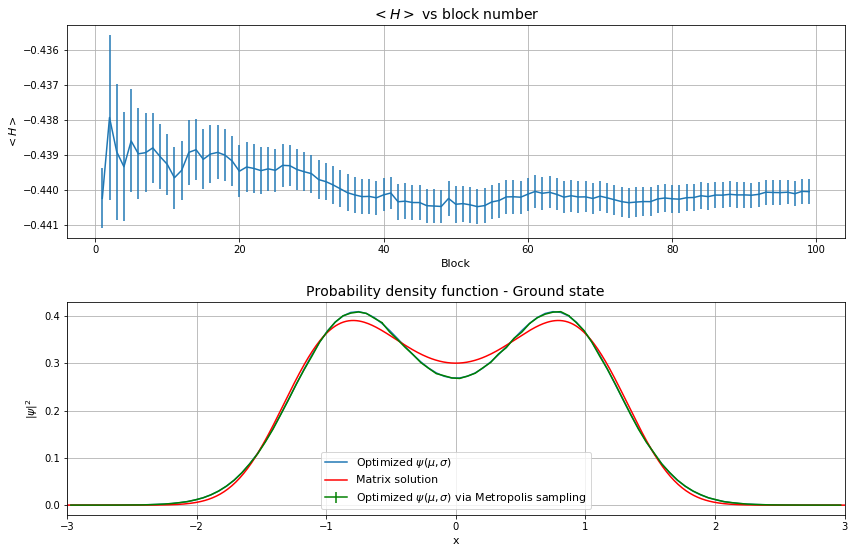

In [3]:
file=open("Es_lezione_08/dataEx08_1.dat")
line1=file.readline().split()
M=int(line1[0])
N=int(line1[1])
line2=file.readline().split()
mu=abs(float(line2[0]))
sigma=abs(float(line2[1]))
x2=np.arange(1, N)
ave=np.zeros(N-1)
err=np.zeros(N-1)
i=0

for line in file.readlines():
        ave[i]=line.split()[0]
        err[i]=line.split()[1]
        i+=1
file.close()

file=open("Es_lezione_08/PsiT_sq_mod.dat")
line1=file.readline().split()
min=float(line1[0])
max=float(line1[1])
nbins=int(line1[2])
nbins=100
h=np.zeros(nbins)
x1=np.zeros(nbins)
err1=np.zeros(nbins)
i=0

for line in file.readlines():
    x1[i]=float(line.split()[0])
    h[i]=float(line.split()[1])
    err1[i]=float(line.split()[2])
    i+=1
file.close()
Psi=PsiT(x1, mu, sigma)

f, ax=plt.subplots(nrows=2, ncols=1)

ax[0].errorbar(x2, ave, yerr=err)
ax[0].set_title("$< H >$ vs block number", fontsize=14)
ax[0].set_xlabel("Block", fontsize=11)
ax[0].set_ylabel("$< H >$", fontsize=11)
ax[0].grid(True)
ax[1].errorbar(x1, h/np.amax(h)*np.amax(Psi), yerr=err1, label="Optimized $\psi(\mu,\sigma)$ via Metropolis sampling", color="green")
ax[1].plot(x1, Psi, label="Optimized $\psi(\mu,\sigma)$")
ax[1].plot(x,(psi[0])**2, label="Matrix solution", color="red")
ax[1].legend(fontsize=11)
ax[1].set_title("Probability density function - Ground state", fontsize=14)
ax[1].set_xlabel("x", fontsize=11)
ax[1].set_ylabel("$|\psi|^2$", fontsize=11)
ax[1].set_xlim((-3,3))
ax[1].grid(True)
plt.subplots_adjust(left=0.5, bottom=-0.5, right=2.3, top=1.2, wspace=0.1, hspace=0.3)

print("Optimizing parameters: ")
print("\mu      =   " + str(mu))
print("\sigma   =   " + str(sigma))
print("\nGround state energy:")
print("Variational MC:   E_0      =   " + str(ave[N-2]) + "  +/-  " + str(err[N-2]))
print("Discretization:   E_0      =   " + str(E[0]))

The variational MC energy is higher than the one evaluated by discretization. This is of course reasonable because the variational method is only able to yield an upper bound to the GS energy. Nonetheless, the final result is not that bad (differs from the value evaluated via discretization of approximately $0.02$). This follows from the fact that the trial wavefunction is able (for the determined values of the parameters) to resemble the shape of the "actual" eigenfunction at least asymptotically: for $\lvert x\rvert>1$ the two functions overlap reasonably well while closer to the origin they become fairly distinguishable but still exhibit the same "shape" (bump-hollow-bump of different heights).

## Exercise 08.3: Path Integral MC and GS
We now use the Path Integral Ground State algorithm to estimate the wavefunction $\psi_0$ as well as the kinetic and potential energies of the polymer particles. We will use as trial functions the constant $\psi_T=1$ and the linear combination of gaussian with the optimized parameters from Ex 8.01 and will compare the results as the imaginary time propagation interval decreases.

We will, then, raise the temperature (PIGS algorithm works at $T=0$) and see how the eigenfunction change (for fixed imaginary time propagation interval $\tau=8$).

### Path Integral Ground State
Using the provided code, we plot the kinetic and potential energies for a PIGS algorithm with imaginary time propagation $\tau=8.0$ for $M=300$ timeslices. We will also modify the propagation interval and see how long we can reduce it and still get reasonable results.

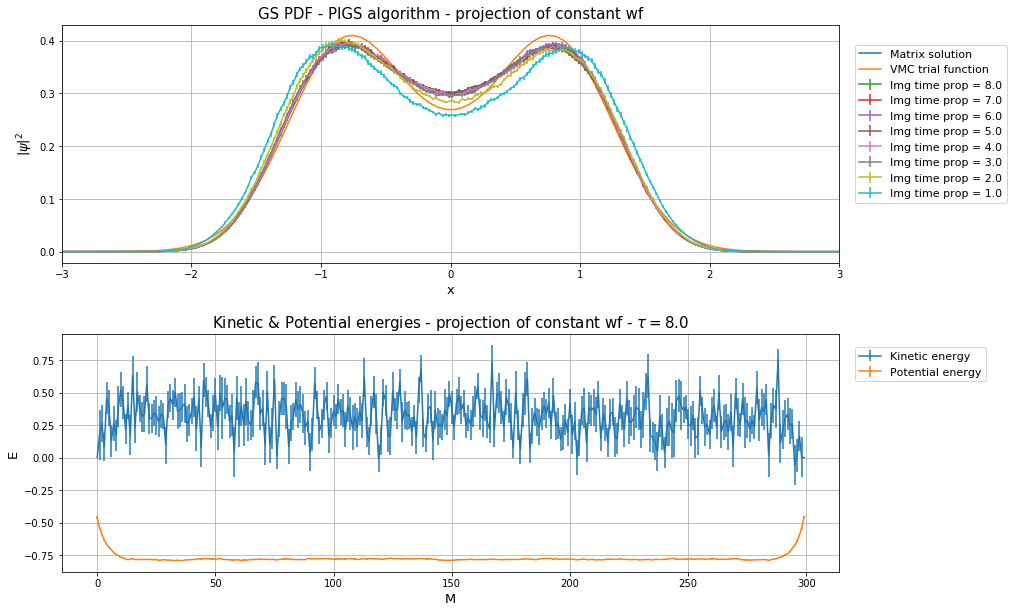

In [10]:
n=8
m=400
timeslices=300
x3=np.empty((n, m))
PsiPIGS=np.empty((n, m))
err=np.empty((n, m))
kin=np.zeros(timeslices)
errkin=np.zeros(timeslices)
pot=np.zeros(timeslices)
errpot=np.zeros(timeslices)
t=np.arange(timeslices)

for i in range(n):
    file=open("Es_lezione_08/probability_PIGS_const_"+ str(i+1) + ".dat")
    j=0
    for line in file.readlines():
        l=line.split()
        x3[i][j]=float(l[0])
        PsiPIGS[i][j]=float(l[1])
        err[i][j]=float(l[2])
        j+=1
    file.close()
    
file=open("Es_lezione_08/kinetic_PIGS_const.dat")
i=0
for line in file.readlines():
    kin[i]=float(line.split()[1])
    errkin[i]=float(line.split()[2])
    i+=1
file.close()

file=open("Es_lezione_08/potential_PIGS_const.dat")
i=0
for line in file.readlines():
    pot[i]=float(line.split()[1])
    errpot[i]=float(line.split()[2])
    i+=1
file.close()

f, ax=plt.subplots(nrows=2, ncols=1)
ax[0].plot(x,(psi[0])**2, label="Matrix solution")
ax[0].plot(x1, Psi, label="VMC trial function")
for i in range(n):
    ax[0].errorbar(x3[i], PsiPIGS[i], yerr=err[i], label="Img time prop = " + str(8.0-i))
ax[0].grid(True)
ax[0].set_xlim((-3,3))
ax[0].legend(loc=(1.02, 0.25), fontsize=11)
ax[0].set_title("GS PDF - PIGS algorithm - projection of constant wf", fontsize=15)
ax[0].set_xlabel("x", fontsize=13)
ax[0].set_ylabel("$|\psi|^2$", fontsize=13)

ax[1].errorbar(t, kin, yerr=errkin, label="Kinetic energy")
ax[1].errorbar(t, pot, yerr=errpot, label="Potential energy")
ax[1].grid(True)
ax[1].set_title(r"Kinetic & Potential energies - projection of constant wf - $\tau=8.0$", fontsize=15)
ax[1].set_xlabel("M", fontsize=13)
ax[1].set_ylabel("E", fontsize=13)
ax[1].legend(loc=(1.02, 0.8), fontsize=11)

plt.subplots_adjust(left=0.5, bottom=-0.7, right=2.3, top=1.2, wspace=0.1, hspace=0.3)

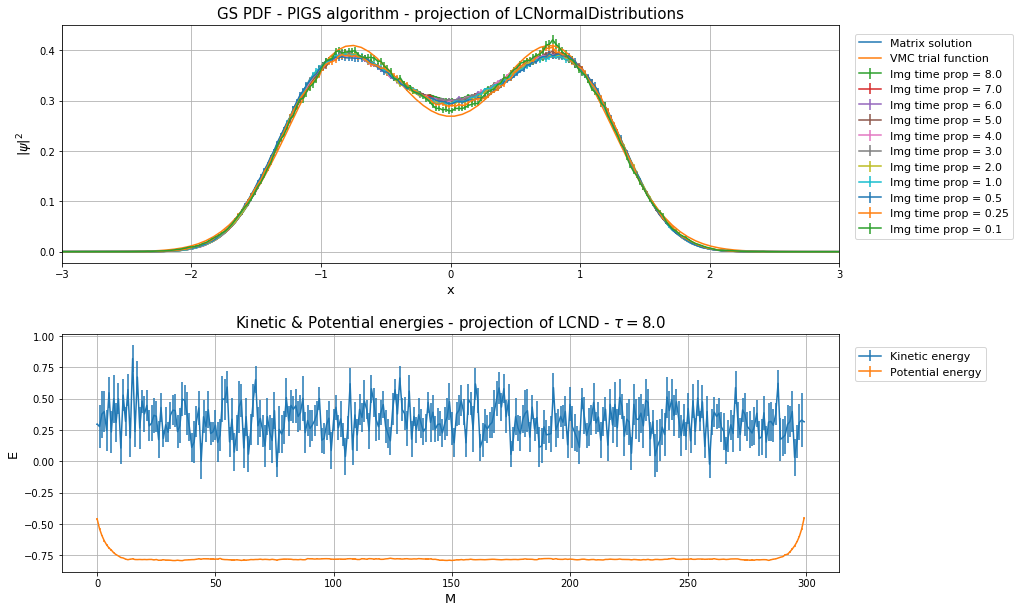

In [11]:
n=11
x3=np.empty((n, m))
PsiPIGS=np.empty((n, m))
err=np.empty((n, m))

kin=np.zeros(timeslices)
errkin=np.zeros(timeslices)
pot=np.zeros(timeslices)
errpot=np.zeros(timeslices)
t=np.arange(timeslices)

for i in range(n):
    file=open("Es_lezione_08/probability_PIGS_gauss_"+ str(i+1) + ".dat")
    j=0
    for line in file.readlines():
        l=line.split()
        x3[i][j]=float(l[0])
        PsiPIGS[i][j]=float(l[1])
        err[i][j]=float(l[2])
        j+=1
    file.close()
    
file=open("Es_lezione_08/kinetic_PIGS_gauss.dat")
i=0
for line in file.readlines():
    kin[i]=float(line.split()[1])
    errkin[i]=float(line.split()[2])
    i+=1
file.close()

file=open("Es_lezione_08/potential_PIGS_const.dat")
i=0
for line in file.readlines():
    pot[i]=float(line.split()[1])
    errpot[i]=float(line.split()[2])
    i+=1
file.close()


for i in range(n):
    file=open("Es_lezione_08/probability_PIGS_gauss_"+ str(i+1) + ".dat")
    j=0
    for line in file.readlines():
        l=line.split()
        x3[i][j]=float(l[0])
        PsiPIGS[i][j]=float(l[1])
        err[i][j]=float(l[2])
        j+=1
    file.close()

f, ax=plt.subplots(nrows=2, ncols=1)

ax[0].plot(x,(psi[0])**2, label="Matrix solution")
ax[0].plot(x1, Psi, label="VMC trial function")
for i in range(n-3):
    ax[0].errorbar(x3[i], PsiPIGS[i], yerr=err[i], label="Img time prop = " + str(8.0-i))
ax[0].errorbar(x3[8], PsiPIGS[8], yerr=err[8], label="Img time prop = 0.5")
ax[0].errorbar(x3[9], PsiPIGS[9], yerr=err[9], label="Img time prop = 0.25" )
ax[0].errorbar(x3[10], PsiPIGS[10], yerr=err[10], label="Img time prop = 0.1")
ax[0].grid(True)
ax[0].set_xlim((-3,3))
ax[0].legend(loc=(1.02, 0.1), fontsize=11)
ax[0].set_title("GS PDF - PIGS algorithm - projection of LCNormalDistributions", fontsize=15)
ax[0].set_xlabel("x", fontsize=13)
ax[0].set_ylabel("$|\psi|^2$", fontsize=13)

ax[1].errorbar(t, kin, yerr=errkin, label="Kinetic energy")
ax[1].errorbar(t, pot, yerr=errpot, label="Potential energy")
ax[1].grid(True)
ax[1].set_title(r"Kinetic & Potential energies - projection of LCND - $\tau=8.0$", fontsize=15)
ax[1].set_xlabel("M", fontsize=13)
ax[1].set_ylabel("E", fontsize=13)
ax[1].legend(loc=(1.02, 0.8), fontsize=11)

plt.subplots_adjust(left=0.5, bottom=-0.7, right=2.3, top=1.2, wspace=0.1, hspace=0.3)

The PIGS algorithm gives results that very well resemble those of the numerical discretization and matrix diagonalization. As the imaginary time propagation interval is reduced, of course we expect that the contribution due to states other than the GS has not yet faded (or become negligeble compared to the statistical uncertainty). The convergence is of course faster if the trial function already resembles the actual eigenfunction, which is why the second choice of $\psi_T$ gives much better results (as far as we can tell, even for $\tau=0.1$ the wavefunction evaluated with the PIGS algorithm is reasonably overlapping with the discretized solution, even though some "memory" of the trial function is preserved especially in the extrema).

As for the energies, the results for the two trial wavefunctions agree (as we should expect because we plotted the data for the longest imaginary time propagation interval and thus both algorithms converge to a fair approximation of the GS). Notice that in both cases there are some 20 particles (namely those at the beginning and at the end of the polymer, even though it being closed makes such concept not well-defined) at higher potential energy than the rest of the chain, while their kinetic energies show no such displacement (they are actually a bit lower for the constant trial wavefunction case but such effect does not replicate for the latter choice). 

### Path Integral Monte Carlo

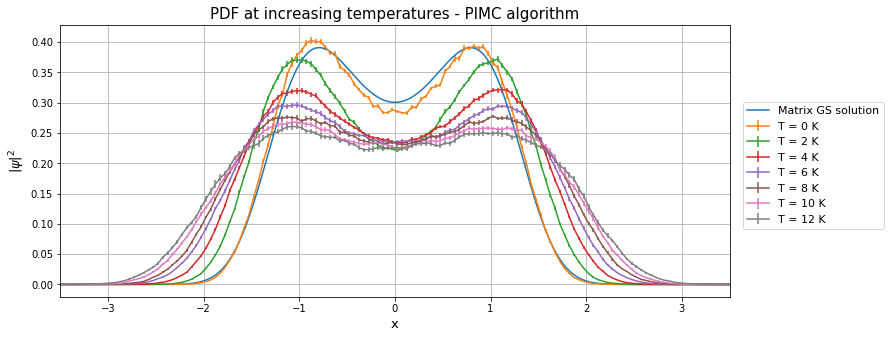

In [7]:
n=7
x3=np.empty((n, m))
PsiPIMC=np.empty((n, m))
err=np.empty((n, m))

for i in range(n):
    file=open("Es_lezione_08/probability_PIMC_"+ str(i+1) + ".dat")
    j=0
    for line in file.readlines():
        l=line.split()
        x3[i][j]=float(l[0])
        PsiPIMC[i][j]=float(l[1])
        err[i][j]=float(l[2])
        j+=1
    file.close()
    

plt.plot(x,(psi[0])**2, label="Matrix GS solution")
for i in range(n):
    plt.errorbar(x3[i], PsiPIMC[i], yerr=err[i], label="T = " + str(2*i) + " K")
plt.grid(True)
plt.xlim((-3.5,3.5))
plt.legend(loc=(1.02, 0.25), fontsize=11)
plt.rcParams["figure.figsize"]=(12,5)
plt.title("PDF at increasing temperatures - PIMC algorithm", fontsize=15)
plt.xlabel("x", fontsize=13)
plt.ylabel("$|\psi|^2$", fontsize=13)
plt.show()

As $T$ is raised, the PDF deviates from the GS as a consequence of the system being not "stuck" in the state of lowest energy. In particular, the distribution lowers and spreads out as a consequence of the excited state eigenfunctions being less and less squeezed around the origin and showing more and more oscillations. 